# White noise object Phase Retrieval

> Georgios Varnavides | Jan 12 2025  
>
> Sample: white-noise object  
> Sampling conditions:2 A^-1 max-scattering angle, Nyquist sampling  
> Imaging conditions: 1 A^-1 semiangle, 200 A defocus, 100 A stig 

In [1]:
# %load_ext autoreload 
# %autoreload 2

In [2]:
import quantem as em
import numpy as np

/Users/gvarnavides/Documents/git-repos/quantem/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
dataset = em.core.io.load("../data/white-noise-object_defocus+stig.zip")
dataset

Dataset(shape=(96, 96, 96, 96), dtype=float64, name='4D-STEM dataset')
  sampling: [0.25       0.25       0.04166667 0.04166667]
  units: ['A', 'A', 'A^-1', 'A^-1']
  signal units: 'arb. units'

In [4]:
energy = 300e3
wavelength = em.core.utils.utils.electron_wavelength_angstrom(energy)
k_probe = 1
semiangle_cutoff = k_probe * wavelength * 1e3

aberration_coefs = {
    "C10": 200,
    "C12": 100,
    "phi12": np.deg2rad(11)
}
rotation_angle = np.deg2rad(-13)

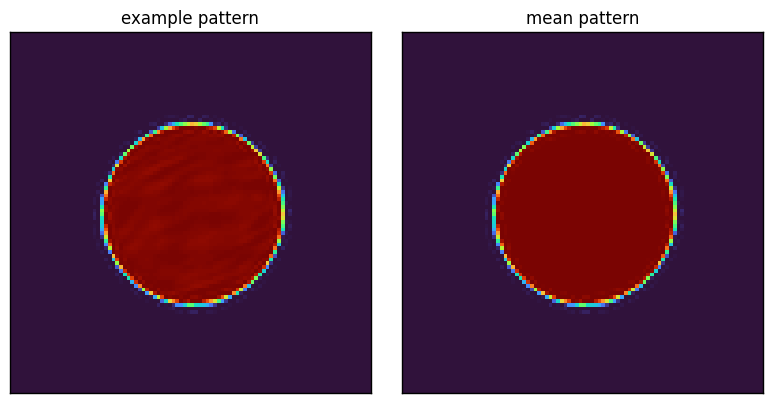

In [5]:
em.visualization.show_2d(
    [
        dataset[0,0].array,
        dataset.mean((0,1)),
    ],
    title=[
        "example pattern","mean pattern"
    ],
    power=0.5,
    cmap='turbo'
);

In [6]:
direct_ptycho = em.diffractive_imaging.DirectPtychography.from_dataset4d(
    dataset,
    energy=energy,
    semiangle_cutoff=semiangle_cutoff,
    rotation_angle=rotation_angle,
    aberration_coefs=aberration_coefs,
    # device='gpu',
)

100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.35it/s]


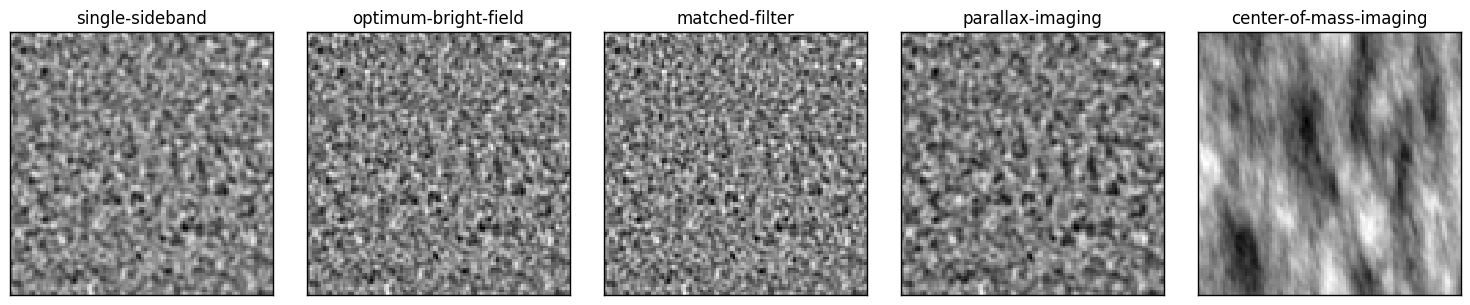

In [7]:
kwargs = {
    "title":["single-sideband","optimum-bright-field","matched-filter","parallax-imaging","center-of-mass-imaging"],
    "norm":"minmax",
    "axsize":(3,3),
}

recons = direct_ptycho._reconstruct_all_permutations(
)

em.visualization.show_2d(
    recons,
    **kwargs
);

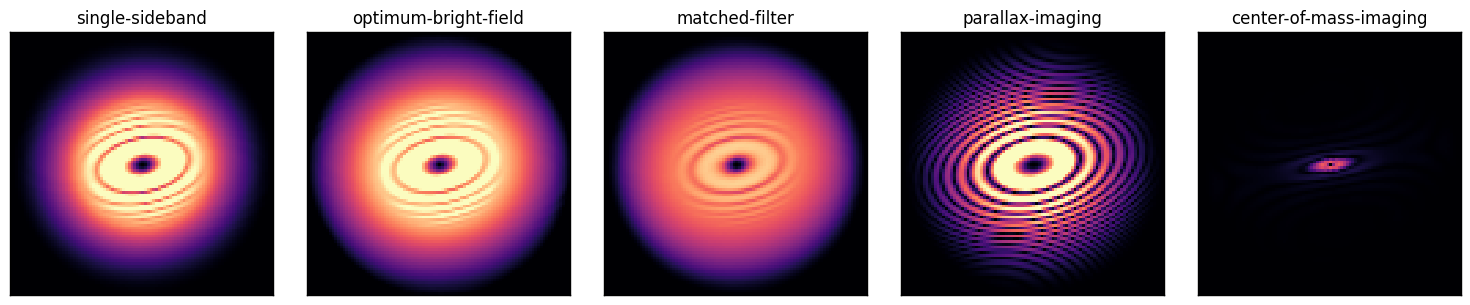

In [8]:
fft_recons = [np.fft.fftshift(np.abs(np.fft.fft2(recon))) for recon in recons]
fft_kwargs = kwargs.copy()
fft_kwargs['cmap'] = "magma"
fft_kwargs['norm'] = em.visualization.NormalizationConfig(
    interval_type="manual",
    vmin=0,
    vmax=1
)

em.visualization.show_2d(
    fft_recons,
    **fft_kwargs
);

In [9]:
# Optimize aberrations and rotation with optuna
direct_ptycho = direct_ptycho.optimize_hyperparameters(
    aberration_coefs={
        "C10":em.diffractive_imaging.direct_ptychography.OptimizationParameter(0,500),
        "C12":em.diffractive_imaging.direct_ptychography.OptimizationParameter(0,500),
        "phi12":em.diffractive_imaging.direct_ptychography.OptimizationParameter(-0.5,0.5)
    },
    rotation_angle=em.diffractive_imaging.direct_ptychography.OptimizationParameter(-0.5,0.5),
    n_trials=200,
    deconvolution_kernel='parallax',
)

Best trial: 178. Best value: 6.60773e-12: 100%|███████████████████████████| 200/200 [00:29<00:00,  6.82it/s]


Optimized state:

 HyperparameterState(
  initial_aberrations={'C10': 200.0, 'C12': 100.0, 'phi12': 0.19198621771937624},
  initial_rotation_angle=np.float64(-0.22689280275926285),
  optimized_aberrations={'C10': 200.2907157526551, 'C12': 95.8468830018286, 'phi12': 0.1805434412241485},
  optimized_rotation_angle=-0.2274459099325303,
)


In [10]:
# reference fit from no guess 
direct_ptycho = direct_ptycho.fit_hyperparameters_cross_correlation(
    alignment_method='reference',
    bin_factors=(1,1,1),

    aberration_coefs = {"C10":0,"C12":0,"phi12":0},
    rotation_angle= 0,
)

Aligning (reference): 100%|███████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.83it/s]


Optimized state:

 HyperparameterState(
  initial_aberrations={'C10': 200.0, 'C12': 100.0, 'phi12': 0.19198621771937624},
  initial_rotation_angle=np.float64(-0.22689280275926285),
  optimized_aberrations={'C10': 190.7965087890625, 'C12': 97.47371673583984, 'phi12': 0.16502520442008972},
  optimized_rotation_angle=-0.1979220062494278,
)


In [13]:
# least squares fit from no guess
direct_ptycho = direct_ptycho.fit_hyperparameters_least_squares(
    aberration_coefs = {"C10":0,"C12":0,"phi12":0},
    cartesian_basis="low_order",
    q_signal_weight=0.0,
    num_q_modes=12,
    verbose=True,
)

Fitting aberrations: 100%|█| 3/3 [00:01<00:00,  1.63order/s, ['C10', 'C12_a', 'C12_b', 'C21_a', 'C21_b', 'C3


Optimized state:

 HyperparameterState(
  initial_aberrations={'C10': 200.0, 'C12': 100.0, 'phi12': 0.19198621771937624},
  initial_rotation_angle=np.float64(-0.22689280275926285),
  optimized_aberrations={'C10': 200.63002014160156, 'C12': 98.7950439453125, 'phi12': 0.1953463852405548, 'C21': 188.248291015625, 'phi21': 1.8316676616668701, 'C30': 0.003534740535542369},
)
